# Constructing a NEP model
## Introduction

In this tutorial, we will show how to use the ``nep`` executable to train a NEP potential and check the results.
For background on the NEP approach see [this section of the documentation](https://gpumd.org/potentials/nep).


## Prerequisites
You need to have access to an Nvidia GPU with compute capability >= 3.5. CUDA 9.0 or higher is also needed to compile the GPUMD package.
You can download GPUMD, unpack it, go to the ``src`` directory, and type ``make -j`` to compile. Then, you should get two executables: ``gpumd`` and ``nep`` in the ``src`` directory.

## Train a NEP potential for PbTe
To train a NEP potential, one must prepare at least two input files: ``train.xyz`` and ``nep.in``. The ``train.xyz`` file contains all the training data, and the `nep.in` file contains some controlling parameters. One can also optionally provide a ``test.xyz`` file that contains all the testing data.

### Prepare the train.xyz and test.xyz files
- The ``train.xyz``/``test.xyz`` file should be prepared according to the [documentation](https://gpumd.org/nep/input_files/).
- For the example in this tutorial, we have already prepared the ``train.xyz`` and ``test.xyz`` files in the current folder, which contain 25 and 300 structures, respectively.
- In this example, there are only energy and force training data. In general, one can also have virial training data.
- We used the VASP code to calculate the training data, but ``nep`` does not care about this. You can generate the data in ``train.xyz``/``test.xyz`` using any method that works for you. For example, before doing new DFT calculations, you can first check if there are training data publicly available and then try to convert them into the format as required by ``train.xyz``/``test.xyz``. There are quite a few tools (https://github.com/brucefan1983/GPUMD/tree/master/tools) available for this purpose.

### Prepare the `nep.in` file. 
- First, study the [documentation about this input file](https://gpumd.org/nep/input_files/).
- For the example in this tutorial, we have prepared the ``nep.in`` file in the current folder. 
- The ``nep.in`` file reads:
```
type         2 Te Pb
```
This is the simplest ``nep.in`` file, with only one keyword, which means that there are $N_{\rm typ}=2$ atom types in the training set: Te and Pb. The user can also write Pb first and Te next. The code will remember the order of the atom types here and record it into the NEP potential file ``nep.txt``. Therefore, the user does not need to remember the order of the atom types here. All the other parameters will have good default values (please check the screen output).
 

### Run the ``nep`` executable
 - Go to the current folder from command line and type
```
path/to/nep # linux
path\to\nep # Windows
```
 
It took about 12 minutes to run 10,000 generations using my laptop with a GeForce RTX 2070 GPU card. One can kill the executable at any time and also restart it by simply running the executable again.

## Check the training results

- After running the `nep` executable, there will be some output on the screen. We encourage the user to read the screen output carefully. It can help to understand the calculation flow of `nep`. 
- Some files will be generated in the current folder and will be updated every 100 generations (some will be updated every 1000 generations). Therefore, one can check the results even before finishing the maximum number of generations as set in `nep.in`. 
- If the user has not studied the documentation of the output files generated by `nep`, it is time to read about those [here](https://gpumd.org/nep/output_files/).
- We will use Python to visualize the results in some of the output files next. We first load ``pylab`` that we need.

In [1]:
from pylab import *

### Checking the ``loss.out`` file
- We see that the $\mathcal{L}_1$ and $\mathcal{L}_2$ regularization loss functions first increases and then decreases, which indicates the effectiveness of the regularization.
- The energy loss is the root mean square error (RMSE) of energy per atom, which converges to about 0.4 meV/atom.
- The force loss is the RMSE of force components, which converges to about 40 meV/Å.

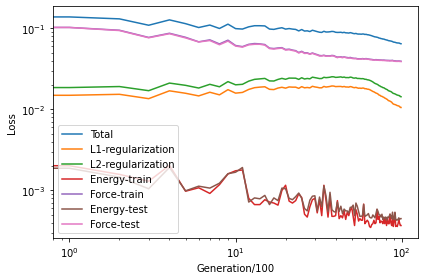

In [2]:
loss = loadtxt('loss.out')
loglog(loss[:, 1:6])
loglog(loss[:, 7:9])
xlabel('Generation/100')
ylabel('Loss')
legend(['Total', 'L1-regularization', 'L2-regularization', 'Energy-train', 'Force-train', 'Energy-test', 'Force-test'])
tight_layout()

### Checking the `energy_test.out` file

The dots are the raw data and the line represents the identity function used to guide the eyes.

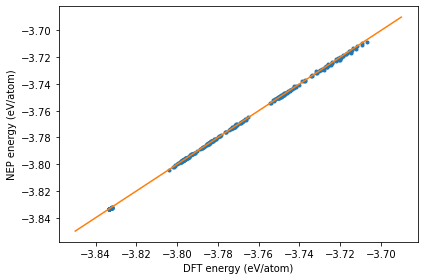

In [3]:
energy_test = loadtxt('energy_test.out')
plot(energy_test[:, 1], energy_test[:, 0], '.')
plot(linspace(-3.85,-3.69), linspace(-3.85,-3.69), '-')
xlabel('DFT energy (eV/atom)')
ylabel('NEP energy (eV/atom)')
tight_layout()

### Checking the `force_test.out` file

The dots are the raw data and the line represents the identity function used to guide the eyes.

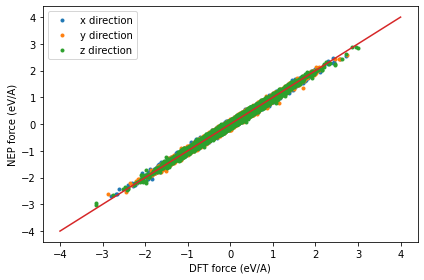

In [5]:
force_test = loadtxt('force_test.out')
plot(force_test[:, 3:6], force_test[:, 0:3], '.')
plot(linspace(-4,4), linspace(-4,4), '-')
xlabel('DFT force (eV/A)')
ylabel('NEP force (eV/A)')
legend(['x direction', 'y direction', 'z direction'])
tight_layout()

### Checking the `virial_test.out` file
In general, one can similarly check the `virial_test.out` file, but in this particular example, virial data were not used in the training process (no virial data exist in ``train.xyz``/``test.xyz``). 

### Checking the other files
One can similarly check the other files: ``energy_train.out``, ``force_train.out``, and ``virial_train.out``. 

## Restart
- After each 100 steps, the ``nep.restart`` file will be updated.
- If ``nep.restart`` exists, it means you want to continue the previous training. Remember not to change the parameters related to the descriptor and the number of neurons. Otherwise the restarting behavior is undefined.
- If you want to train from scratch, you need to delete ``nep.restart`` first (better to first make a copy of all the results from the previous training).